<a href="https://colab.research.google.com/github/AurelienNioche/ActiveTeachingCollaborative/blob/main/with_artificial_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install arviz

In [2]:
!pip install numpy --upgrade

In [3]:
!pip install pymc3 --upgrade

In [4]:
!pip install --upgrade tqdm

In [5]:
import os
# os.environ['THEANO_FLAGS'] = 'device=cuda,force_device=True,floatX=float32'
import numpy as np
import pandas as pd
import scipy.stats
import pymc3 as pm
import arviz as az
import theano.tensor as tt
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [6]:
import theano
theano.config.device

'cpu'

In [7]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Produce data

In [8]:
class Leitner:
    def __init__(self, n_item, delay_factor, delay_min):

        box = np.full(n_item, -1)
        due = np.full(n_item, -1)

        self.n_item = n_item

        self.delay_factor = delay_factor
        self.delay_min = delay_min

        self.box = box
        self.due = due

    def update_box_and_due_time(self, last_idx, last_was_success, last_time_reply):

        if last_was_success:
            self.box[last_idx] += 1
        else:
            self.box[last_idx] = max(0, self.box[last_idx] - 1)

        delay = self.delay_factor ** self.box[last_idx]
        # Delay is 1, 2, 4, 8, 16, 32, 64, 128, 256, 512 ... minutes
        self.due[last_idx] = last_time_reply + self.delay_min * delay

    def _pickup_item(self, now):

        seen = np.argwhere(np.asarray(self.box) >= 0).flatten()
        n_seen = len(seen)

        if n_seen == self.n_item:
            return np.argmin(self.due)

        else:
            seen__due = np.asarray(self.due)[seen]
            seen__is_due = np.asarray(seen__due) <= now
            if np.sum(seen__is_due):
                seen_and_is_due__due = seen__due[seen__is_due]

                return seen[seen__is_due][np.argmin(seen_and_is_due__due)]
            else:
                return self._pickup_new()

    def _pickup_new(self):
        return np.argmin(self.box)

    def ask(self, now, last_was_success, last_time_reply, idx_last_q):

        if idx_last_q is None:
            item_idx = self._pickup_new()

        else:

            self.update_box_and_due_time(
                last_idx=idx_last_q,
                last_was_success=last_was_success,
                last_time_reply=last_time_reply,
            )
            item_idx = self._pickup_item(now)

        return item_idx

In [9]:
np.random.seed(123)
n_item = 500

ss_n_iter = 100
time_per_iter = 4
n_sec_day = 24 * 60**2
n_ss = 100
eval_ts = n_ss * n_sec_day

reviews_list = [np.arange(x, x + (ss_n_iter * time_per_iter), time_per_iter) 
                for x in np.arange(n_sec_day * n_ss, step=n_sec_day)]
review_ts = np.hstack(reviews_list)

In [10]:
def run(param, agent=0, c=1e-05):
    bkp = []

    n_total_iter = len(review_ts)

    rd = np.log(np.random.random(size=n_total_iter))

    is_it_spec = len(np.asarray(param).shape) > 1

    lei = Leitner(n_item=n_item, delay_min=4, delay_factor=2)

    n_rep = np.full(n_item, -1, dtype=int)
    last_pres = np.zeros(n_item)

    last_item = None
    last_success = None
    last_ts = None

    for i, ts in enumerate(review_ts):

        item = lei.ask(
            now=ts,
            idx_last_q=last_item,
            last_was_success=last_success,
            last_time_reply=last_ts)

        if is_it_spec:
            α, β = param[item, 0], param[item, 1]
        else:
            α, β = param[0], param[1]
            
        delta_rep = ts - last_pres[item]
        n_rep_i = n_rep[item]
        if n_rep_i < 0:
            success = False
        else:
            lp = - α * (1 - β)**n_rep_i * delta_rep * c
            success = lp > rd[i]
            
            # Backup
            bkp.append({
                "agent": agent,
                "item": item, "success": success, 
                "n_rep": n_rep_i, 
                "delta_rep": delta_rep})

        # Update values
        n_rep[item] += 1
        last_pres[item] = ts
        last_success = success
        last_ts = ts
        last_item = item
    return pd.DataFrame(bkp)

In [11]:
df = run([5.0, 0.3])
df

,agent,item,success,n_rep,delta_rep
0,0,0,True,0,4.0
1,0,0,True,1,8.0
2,0,1,True,0,8.0
3,0,1,True,1,8.0
4,0,2,True,0,8.0
...,...,...,...,...,...
9548,0,444,True,0,4.0
9549,0,443,True,2,16.0
9550,0,444,True,1,8.0
9551,0,445,True,0,4.0


In [12]:
df.success.mean()

0.9179315398304198

# Inference for a single individual

In [13]:
delta_rep = df.delta_rep.values
n_rep = df.n_rep.values
success = df.success

eps = np.finfo(float).eps
c = 1e-05

with pm.Model() as model:

    α = pm.HalfFlat('α')  # pm.Bound(pm.Flat, lower=0.02, upper=2500.0) # pm.TruncatedNormal('α', mu=2.0, sigma=1.0, lower=0.02, upper=2500.0)
    β = pm.Bound(pm.Flat, lower=0.0, upper=1.0)('β')  # pm.TruncatedNormal('β', mu=0.1, sigma=0.1, lower=0.0, upper=1.0)

    lp = - delta_rep * α * (1 - β) ** n_rep * c
    logit_p = lp - np.log(1-np.exp(lp) + eps)

    recall = pm.Bernoulli('recall', logit_p=logit_p, observed=success)

In [14]:
with model:
    trace = pm.sample(1000, tune=1000, chains=2, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, α]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 22 seconds.
The acceptance probability does not match the target. It is 0.8985860435947672, but should be close to 0.8. Try to increase the number of tuning steps.


In [15]:
trace_sm = az.summary(trace)
trace_sm

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
α,5.002,0.343,4.401,5.671,0.014,0.01,603.0,598.0,609.0,649.0,1.01
β,0.301,0.006,0.291,0.312,0.000,0.00,606.0,606.0,604.0,876.0,1.01


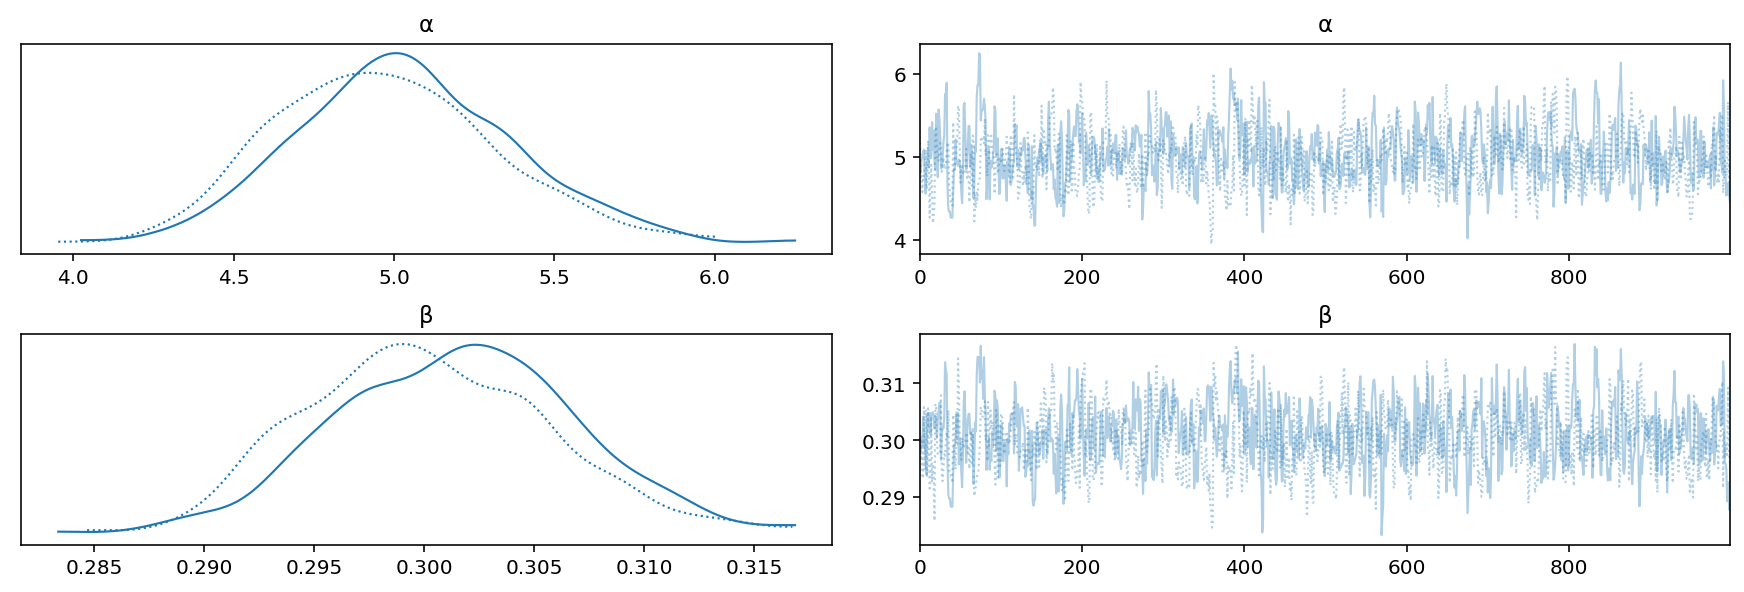

In [16]:
az.plot_trace(trace, var_names=['α', 'β'])
plt.show()

# Make data for a population 

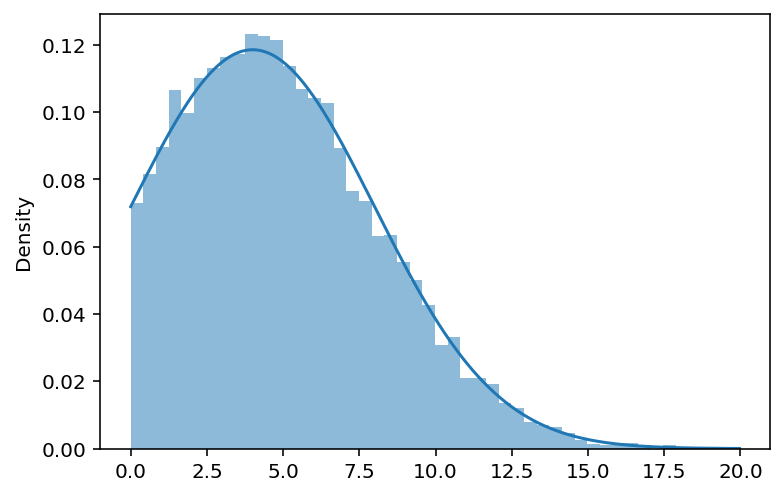

In [17]:
m_alpha = 4
s_alpha = 4
fig, ax = plt.subplots()

a = 0 # 15
b = np.inf # 25 # np.inf

kwargs_alpha = dict(loc=m_alpha, scale=s_alpha, a=(a-m_alpha)/s_alpha, b=(b-m_alpha)/s_alpha)

x = scipy.stats.truncnorm.rvs(size=10000, **kwargs_alpha)
sns.histplot(x, alpha=0.5, linewidth=0, stat="density", ax=ax, color='C0')
x_th = np.linspace(0, np.max(x), 1000)
y_th = scipy.stats.truncnorm.pdf(x_th, **kwargs_alpha)
ax.plot(x_th, y_th, color='C0', label="theoretical distribution", ls='-')
plt.show()

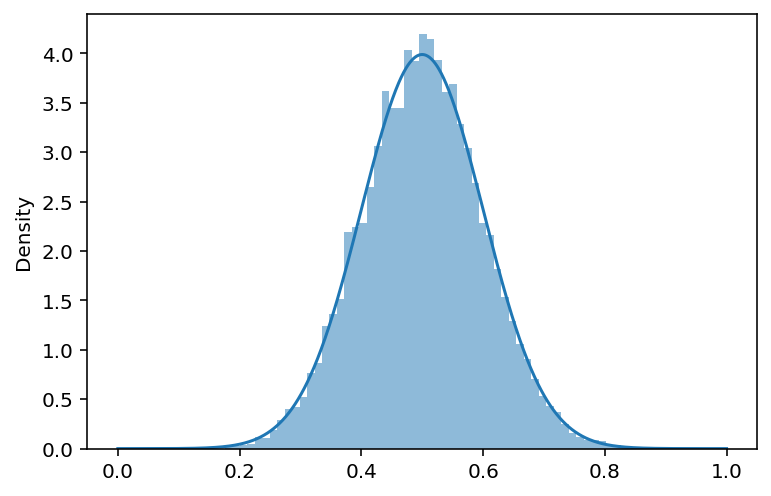

In [21]:
m_beta = 0.5
s_beta = 0.1
fig, ax = plt.subplots()

a = 0 # 15
b = 1 # 25 # np.inf

kwargs_beta = dict(loc=m_beta, scale=s_beta, a=(a-m_beta)/s_beta, b=(b-m_beta)/s_beta)

x = scipy.stats.truncnorm.rvs(size=10000, **kwargs_beta)
sns.histplot(x, alpha=0.5, linewidth=0, stat="density", ax=ax, color='C0')
x_th = np.linspace(0, 1, 1000)
y_th = scipy.stats.truncnorm.pdf(x_th, **kwargs_beta)
ax.plot(x_th, y_th, color='C0', label="theoretical distribution", ls='-')
plt.show()

In [26]:
n = 5
param = np.vstack((scipy.stats.truncnorm.rvs(size=n, **kwargs_alpha), 
                   scipy.stats.truncnorm.rvs(size=n, **kwargs_beta))).T
df_param = pd.DataFrame(param, columns=('α', 'β'))
df_param

,α,β
0,5.511833,0.607889
1,5.250130,0.460730
2,7.332934,0.413740
3,8.420277,0.471476
4,5.558440,0.481564


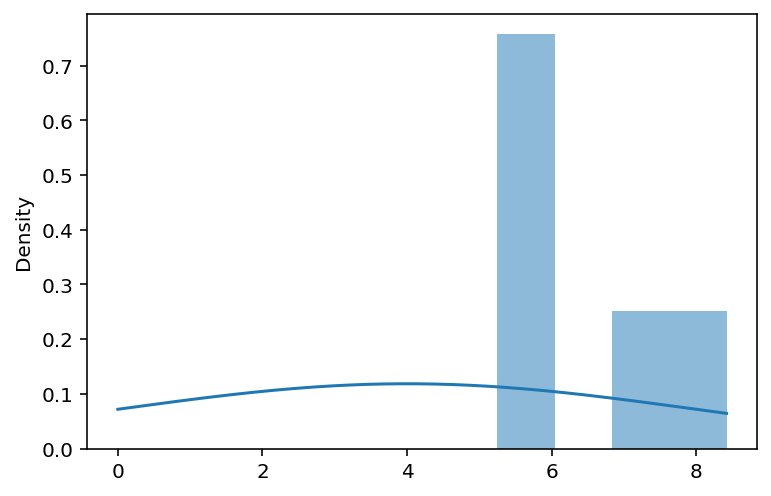

In [27]:
fig, ax = plt.subplots()

x = df_param.α.values
sns.histplot(x, alpha=0.5, linewidth=0, stat="density", ax=ax, color='C0')
x_th = np.linspace(0, np.max(x), 1000)
y_th = scipy.stats.truncnorm.pdf(x_th, **kwargs_alpha)
ax.plot(x_th, y_th, color='C0', label="theoretical distribution", ls='-')
plt.show()

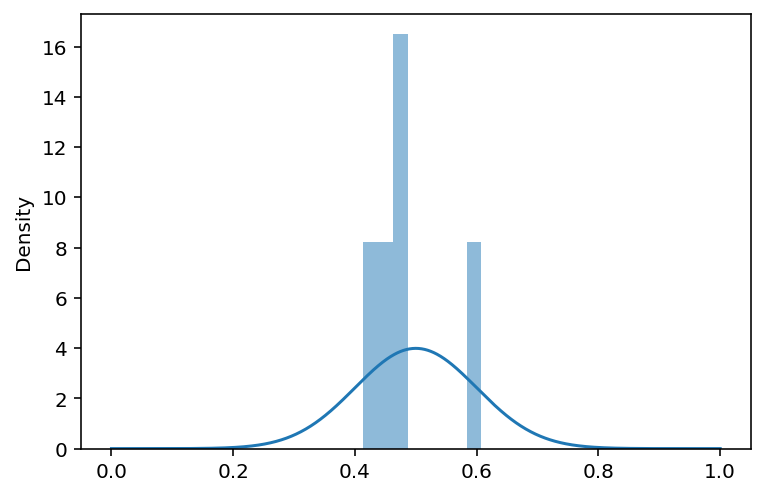

In [28]:
fig, ax = plt.subplots()

x = df_param.β.values
sns.histplot(x, alpha=0.5, linewidth=0, stat="density", ax=ax, color='C0')
x_th = np.linspace(0, 1, 1000)
y_th = scipy.stats.truncnorm.pdf(x_th, **kwargs_beta)
ax.plot(x_th, y_th, color='C0', label="theoretical distribution", ls='-')

In [29]:
r = []
for i, pr in tqdm(enumerate(param), total=len(param)):
    r.append(run(pr, agent=i))

df = pd.concat(r)
df

100%|██████████| 5/5 [00:02<00:00,  2.44it/s]


,agent,item,success,n_rep,delta_rep
0,0,0,True,0,4.0
1,0,0,True,1,8.0
2,0,1,True,0,8.0
3,0,1,True,1,8.0
4,0,2,True,0,8.0
...,...,...,...,...,...
9504,4,489,True,1,20.0
9505,4,490,True,0,20.0
9506,4,487,True,3,40.0
9507,4,485,True,6,64.0


In [30]:
df.groupby("agent")["success"].mean()

agent
0    0.982105
1    0.962675
2    0.943646
3    0.959218
4    0.964981
Name: success, dtype: float64

In [31]:
eps = np.finfo(float).eps

# Independent modeling

In [32]:
with pm.Model() as model:
    
    α = pm.HalfFlat('α', shape=n)  # pm.Bound(pm.Flat, lower=0.02, upper=2500.0) # pm.TruncatedNormal('α', mu=2.0, sigma=1.0, lower=0.02, upper=2500.0)
    β = pm.Bound(pm.Flat, lower=0.0, upper=1.0)('β', shape=n) 

    to_concat = []
    
    for i in range(n):
        df_a = df[df.agent == i]
        n_rep, delta_rep = df_a.n_rep.values, df_a.delta_rep.values
        
        alpha = α[i]
        beta = β[i]
        
        lp = - delta_rep * alpha * (1 - beta) ** n_rep * 1e-05
        logit_p = lp - np.log(1 - np.exp(lp) + eps)
        
        to_concat.append(logit_p)
    
    logit_p_all = tt.concatenate(to_concat)
    success = df.success.astype(bool).values
    
    recall = pm.Bernoulli('recall', logit_p=logit_p_all, observed=success)

In [33]:
with model:
    # trace = pm.sample(1000, tune=1000, chains=2, return_inferencedata=False)
    trace = pm.find_MAP() # pm.sample(1000, tune=1000, chains=2, return_inferencedata=True)

In [34]:
trace_sm = az.summary(trace)
trace_sm

arviz - WARNING - Shape validation failed: input_shape: (1, 5), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
α_log__,1.863,0.252,1.559,2.216,0.162,0.133,2.0,2.0,2.0,2.0,NaN
β_interval__,-0.042,0.369,-0.411,0.569,0.238,0.194,2.0,2.0,2.0,2.0,NaN
α,6.612,1.697,4.754,9.168,1.093,0.893,2.0,2.0,2.0,2.0,NaN
β,0.489,0.090,0.399,0.639,0.058,0.048,2.0,2.0,2.0,2.0,NaN


# Hierarchical Modeling

In [35]:
with pm.Model() as model:
    
    # mu_a = pm.HalfFlat("mu_a")
    # sigma_a = pm.HalfFlat("sigma_a")
    # mu_b = pm.Bound(pm.Flat,lower=0, upper=1)("mu_b")
    # sigma_b = pm.HalfFlat("sigma_b")
    mu_a = pm.TruncatedNormal("mu_a", mu=1, sigma=100, lower=0)
    sg_a = pm.HalfNormal("sg_a", sigma=10)
    mu_b = pm.TruncatedNormal("mu_b", mu=0, sigma=0.25, lower=0, upper=1)
    sg_b = pm.TruncatedNormal("sg_b", mu=0, sigma=0.25, lower=0, upper=0.5)  # max is sqrt((1/4)*(b-a)^2)
    
    α = pm.TruncatedNormal('α', mu=mu_a, sigma=sg_a, lower=0.0, shape=n)
    β = pm.TruncatedNormal('β', mu=mu_b, sigma=sg_b, lower=0.0, upper=1.0, shape=n)
    
    to_concat = []
    
    for i in range(n):
        df_a = df[df.agent == i]
        n_rep, delta_rep = df_a.n_rep.values, df_a.delta_rep.values
        
        alpha = α[i]
        beta = β[i]
        
        lp = - delta_rep * alpha * (1 - beta) ** n_rep * 1e-05
        logit_p = lp - np.log(1 - np.exp(lp) + eps)
        
        to_concat.append(logit_p)

#     lp = - delta_rep * alpha * (1 - beta) ** n_rep * 1e-05
#     logit_p = lp - np.log(1 - np.exp(lp) + eps)
    # logit_p = alpha / pm.math.maximum(alpha)
    
    
    logit_p_all = tt.concatenate(to_concat)
    success = df.success.astype(bool).values
    
    recall = pm.Bernoulli('recall', logit_p=logit_p_all, observed=success)

In [36]:
with model:
    # trace = pm.sample(1000, tune=1000, chains=2, return_inferencedata=True)
    start = pm.find_MAP()
    trace = pm.sample(1000, tune=1000, chains=2, cores=1, return_inferencedata=True, start=start)

WARNING (theano.tensor.opt): Optimization Warning: The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [β, α, sg_b, mu_b, sg_a, mu_a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 997 seconds.
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [37]:
trace_sm = az.summary(trace)
trace_sm

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu_a,6.171,1.738,1.903,9.069,0.097,0.069,322.0,322.0,471.0,239.0,1.01
sg_a,2.869,2.273,0.512,6.756,0.105,0.074,472.0,472.0,275.0,99.0,1.02
mu_b,0.449,0.086,0.262,0.588,0.005,0.003,357.0,357.0,571.0,357.0,1.00
sg_b,0.139,0.081,0.044,0.311,0.005,0.003,319.0,312.0,462.0,356.0,1.00
α[0],6.622,0.997,4.870,8.547,0.028,0.020,1255.0,1255.0,1222.0,1079.0,1.00
α[1],5.640,0.609,4.528,6.753,0.018,0.013,1099.0,1051.0,1137.0,1351.0,1.00
α[2],6.975,0.611,5.923,8.172,0.018,0.013,1176.0,1176.0,1130.0,349.0,1.00
α[3],8.652,1.029,6.885,10.586,0.035,0.025,848.0,848.0,807.0,1194.0,1.00
α[4],5.010,0.559,4.039,6.040,0.021,0.016,699.0,637.0,780.0,805.0,1.00
β[0],0.634,0.019,0.599,0.670,0.001,0.000,1197.0,1197.0,1222.0,1013.0,1.00


In [ ]:
az.plot_posterior(trace, var_names=['mu_a', 'mu_b', 'sigma_a', 'sigma_b'])

In [ ]:
# for i in range(n):
    
#     df_a = df[df.agent == i]
#     n_rep, delta_rep, success = df_a.n_rep.values, df_a.delta_rep.values, df_a.success.astype(bool).values
#     eps = np.finfo(float).eps
    
#     with pm.Model() as model:

#         α = pm.TruncatedNormal('α', mu=2.0, sigma=1.0, lower=0.02, upper=2500.0)
#         β = pm.TruncatedNormal('β', mu=0.1, sigma=0.1, lower=0.0, upper=1.0)

#         lp = - delta_rep * α * (1 - β) ** n_rep * 1e-05
#         logit_p = lp - np.log(1-np.exp(lp) + eps)

#         recall = pm.Bernoulli('recall', logit_p=logit_p, observed=success)

#     with model:
#         trace = pm.sample(1000, tune=1000, chains=2, return_inferencedata=True)
#     trace_sm = az.summary(trace)
#     print(trace_sm.loc['α', 'mean'], param[i, 0])
#     print(trace_sm.loc['β', 'mean'], param[i, 1])

In [ ]:
# m = 4
# sig = 5
# fig, ax = plt.subplots()
# x = scipy.stats.halfnorm.rvs(loc=m, scale=sig, size=1000)
# sns.histplot(x, alpha=0.5, linewidth=0, stat="density", ax=ax, color='C0')
# x_th = np.linspace(0, np.max(x), 1000)
# y_th = scipy.stats.halfnorm.pdf(x_th, loc=m, scale=sig)
# ax.plot(x_th, y_th, color='C0', label="theoretical distribution", ls='-')